In [1]:
pip install requests pandas networkx plotly nbformat python-louvain



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade nbformat


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import combinations
from collections import Counter
import networkx as nx
import community.community_louvain as community


In [4]:
response = requests.get("https://api.openalex.org/concepts?search=engineering biology")
print(response.json())

{'meta': {'count': 8, 'db_response_time_ms': 50, 'page': 1, 'per_page': 25, 'groups_count': None}, 'results': [{'id': 'https://openalex.org/C136229726', 'wikidata': 'https://www.wikidata.org/wiki/Q327092', 'display_name': 'Biomedical engineering', 'relevance_score': 3658.192, 'level': 1, 'description': 'application of engineering principles and design concepts to medicine and biology for healthcare purposes', 'works_count': 678467, 'cited_by_count': 14365412, 'summary_stats': {'2yr_mean_citedness': 3.922209726907965, 'h_index': 769, 'i10_index': 234664}, 'ids': {'openalex': 'https://openalex.org/C136229726', 'wikidata': 'https://www.wikidata.org/wiki/Q327092', 'mag': '136229726', 'wikipedia': 'https://en.wikipedia.org/wiki/Biomedical%20engineering', 'umls_cui': ['C0005539']}, 'image_url': 'https://upload.wikimedia.org/wikipedia/commons/0/0e/%%D0%%9E%%D0%%BF%%D0%%B5%%D1%%80%%D0%%B0%%D1%%86%%D0%%B8%%D0%%BE%%D0%%BD%%D0%%BD%%D0%%B0%%D1%%8F._%%D0%%A4%%D0%%A6%%D0%%9D_%%28%%D0%%A2%%D1%%8E%%D0

In [5]:
url = "https://api.openalex.org/works"
params = {
    'filter': 'concepts.id:C136229726',
    'per-page': 200
}

response = requests.get(url, params=params)
data = response.json()

In [6]:
print(response.status_code)
print(data) #print

200
{'meta': {'count': 666155, 'db_response_time_ms': 342, 'page': 1, 'per_page': 200, 'groups_count': None}, 'results': [{'id': 'https://openalex.org/W2418802570', 'doi': 'https://doi.org/10.1126/science.1957169', 'title': 'Optical Coherence Tomography', 'display_name': 'Optical Coherence Tomography', 'publication_year': 1991, 'publication_date': '1991-11-22', 'ids': {'openalex': 'https://openalex.org/W2418802570', 'doi': 'https://doi.org/10.1126/science.1957169', 'mag': '2418802570', 'pmid': 'https://pubmed.ncbi.nlm.nih.gov/1957169', 'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/4638169'}, 'language': 'en', 'primary_location': {'is_oa': False, 'landing_page_url': 'https://doi.org/10.1126/science.1957169', 'pdf_url': None, 'source': {'id': 'https://openalex.org/S3880285', 'display_name': 'Science', 'issn_l': '0036-8075', 'issn': ['0036-8075', '1095-9203'], 'is_oa': False, 'is_in_doaj': False, 'is_core': True, 'host_organization': 'https://openalex.org/P4310315823', 'host_organiz

In [7]:
#Get the information (Authors, Institutions, Countries, Citations)
works = data['results']

records = []
for work in works:
    title = work.get('title', 'N/A')
    citations = work.get('cited_by_count', 0)
    
    authors = []
    institutions = []
    countries = []
    
    for author in work.get('authorships', []):
        author_name = author['author']['display_name']
        authors.append(author_name)
        
        if 'institutions' in author and author['institutions']:
            for inst in author['institutions']:
                institutions.append(inst.get('display_name', 'Unknown'))
                country = inst.get('country_code', 'N/A')
                if country is None:
                    country = 'N/A'
                countries.append(country)
        else:
            institutions.append('N/A')
            countries.append('N/A')
    
    records.append({
        'Title': title,
        'Authors': ', '.join(authors),
        'Institutions': ', '.join(institutions),
        'Countries': ', '.join(countries),
        'Citations': citations
    })

df = pd.DataFrame(records)


In [8]:
#explore
print(df.info()) 
print(df.describe())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         200 non-null    object
 1   Authors       200 non-null    object
 2   Institutions  200 non-null    object
 3   Countries     200 non-null    object
 4   Citations     200 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 7.9+ KB
None
          Citations
count    200.000000
mean    2488.595000
std     1389.330644
min     1530.000000
25%     1718.750000
50%     2038.000000
75%     2556.000000
max    12984.000000


In [9]:
print("Unique Articles:", df['Title'].nunique())
print("Unique Authors:", df['Authors'].str.split(', ').explode().nunique())
print("Unique Countries:", df['Countries'].str.split(', ').explode().nunique())

#unique institutions
print("Unique Institutions:", df['Institutions'].str.split(', ').explode().nunique())


Unique Articles: 199
Unique Authors: 665
Unique Countries: 29
Unique Institutions: 242


In [10]:
top_authors = df['Authors'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Authors:\n", top_authors)

top_institutions = df['Institutions'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Institutions:\n", top_institutions)


Top 10 Authors:
 Authors
David Mooney            6
Róbert Langer           6
Dietmar W. Hutmacher    4
Cato T. Laurencin       4
David L. Kaplan         4
Larry L. Hench          4
Ali Khademhosseini      4
Margaret M. Bradley     3
Jennifer L. West        3
Peter J. Lang           3
Name: count, dtype: int64
Top 10 Institutions:
 Institutions
N/A                                                       67
Harvard University                                        60
Massachusetts Institute of Technology                     36
Rice University                                           20
University of Michigan–Ann Arbor                          20
Tufts University                                          19
Brigham and Women's Hospital                              17
Case Western Reserve University                           17
Harvard–MIT Division of Health Sciences and Technology    16
University of Pennsylvania                                14
Name: count, dtype: int64


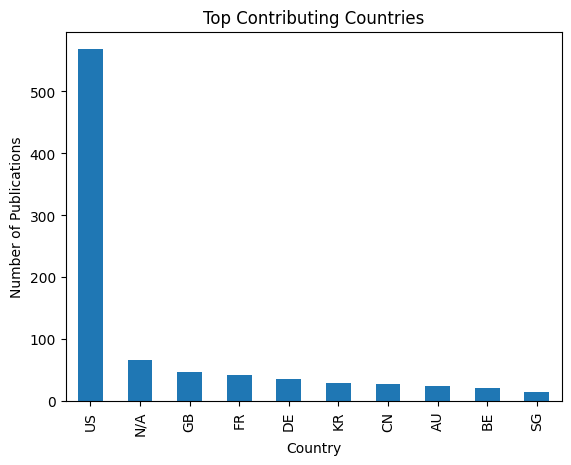

In [11]:
#countries
top_countries = df['Countries'].str.split(', ').explode().value_counts().head(10)
top_countries.plot(kind='bar')
plt.title("Top Contributing Countries")
plt.xlabel("Country")
plt.ylabel("Number of Publications")
plt.show()


In [12]:
#make the pairs
country_pairs = []
for countries in df['Countries']:
    country_list = list(set(countries.split(', ')))
    country_pairs += list(combinations(country_list, 2))

pair_counts = Counter(country_pairs)
top_pairs = dict(sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10])
print("Top Country Collaborations:\n", top_pairs)


Top Country Collaborations:
 {('US', 'N/A'): 12, ('GB', 'US'): 6, ('US', 'DE'): 4, ('US', 'FR'): 3, ('N/A', 'FR'): 3, ('KR', 'US'): 2, ('DE', 'N/A'): 2, ('DE', 'US'): 2, ('US', 'IT'): 2, ('AU', 'CN'): 2}


In [13]:
#citations
df.groupby('Authors')['Citations'].sum().sort_values(ascending=False).head(10)


Authors
David Huang, Eric A. Swanson, Charles P. Lin, Joel S. Schuman, William G. Stinson, Warren Chang, Michael R. Hee, Thomas Flotte, Kenton W. Gregory, Carmen A. Puliafito, James G. Fujimoto    12984
Larry L. Hench                                                                                                                                                                                9474
Róbert Langer, Joseph P. Vacanti                                                                                                                                                              9136
Tadashi Kokubo, Hiroaki Takadama                                                                                                                                                              8622
Allan S. Hoffman                                                                                                                                                                              7625
Kuen Yong Lee, Da

In [14]:
#double check for empty data. does this get rid of the N/As? 
if df.empty:
    print("No data to analyze.")
else:
    print(df.head())


                                               Title  \
0                       Optical Coherence Tomography   
1                                 Tissue Engineering   
2  How useful is SBF in predicting in vivo bone b...   
3   Alginate: Properties and biomedical applications   
4  Cellulose: Fascinating Biopolymer and Sustaina...   

                                             Authors  \
0  David Huang, Eric A. Swanson, Charles P. Lin, ...   
1                   Róbert Langer, Joseph P. Vacanti   
2                   Tadashi Kokubo, Hiroaki Takadama   
3                        Kuen Yong Lee, David Mooney   
4  Dieter Klemm, Brigitte Heublein, Hans‐Peter Fi...   

                                        Institutions  \
0  Massachusetts Institute of Technology, Massach...   
1  Boston Children's Hospital, Harvard University...   
2                 Chubu University, Chubu University   
3  Hanyang University, Harvard University, Harvar...   
4  Friedrich Schiller University Jena, Friedri

In [15]:
#start with nx
G = nx.Graph()

#create edges
for index, row in df.iterrows():
    authors = row['Authors'].split(', ')
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            if G.has_edge(authors[i], authors[j]):
                G[authors[i]][authors[j]]['weight'] += 1  #maybe do a weight for repeated collaborations
            else:
                G.add_edge(authors[i], authors[j], weight=1)


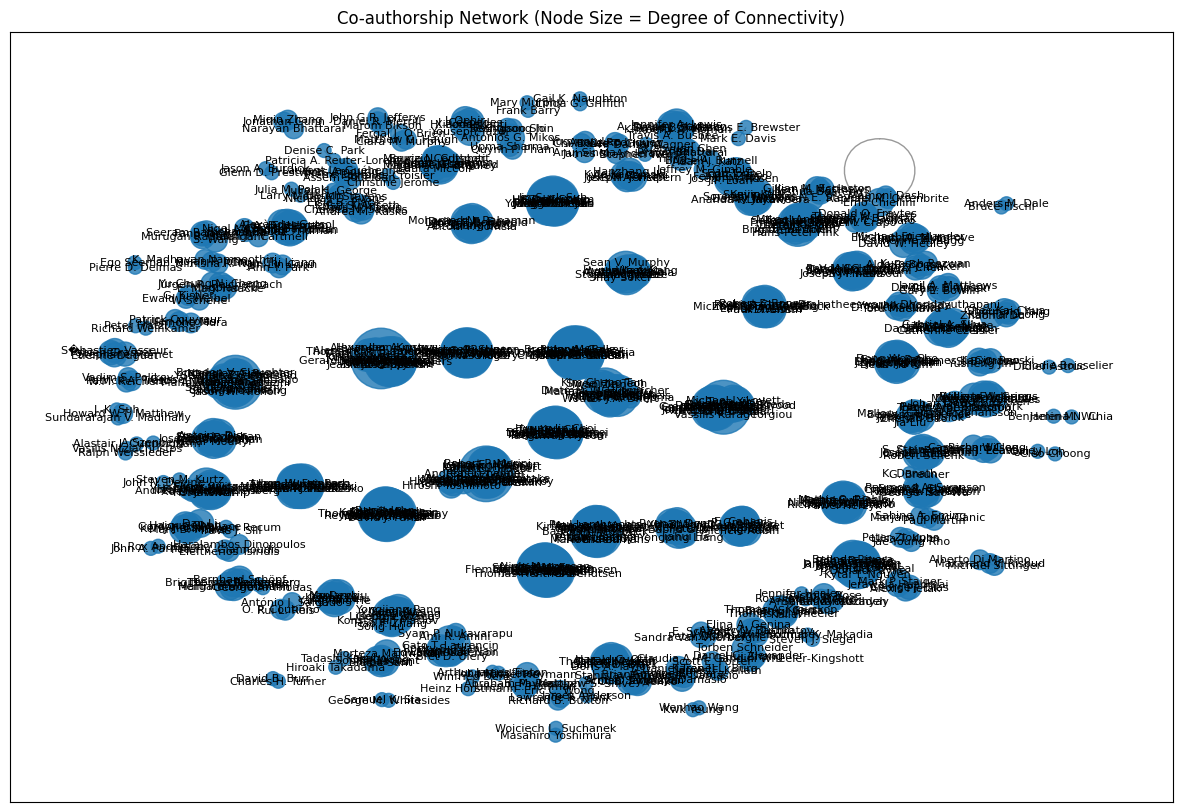

In [16]:
degree = dict(G.degree())
node_size = [v * 100 for v in degree.values()]  #nodes are too small need them larger

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)

#draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=0.8)

#draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4)

#draw labels with reduced overlap
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Co-authorship Network (Node Size = Degree of Connectivity)")
plt.show()


Number of Nodes (Authors): 641
Number of Edges (Collaborations): 1601
Top 10 Authors by Degree Centrality:
David Mooney: 0.03
Róbert Langer: 0.03
David L. Kaplan: 0.02
Ali Khademhosseini: 0.02
Jan De Munck: 0.02
Bart Van Meerbeek: 0.02
H.J.G. Gundersen: 0.02
Peter V. Bagger: 0.02
Thomas Fichtner Bendtsen: 0.02
Stephen M. Evans: 0.02
Number of Communities Detected: 123


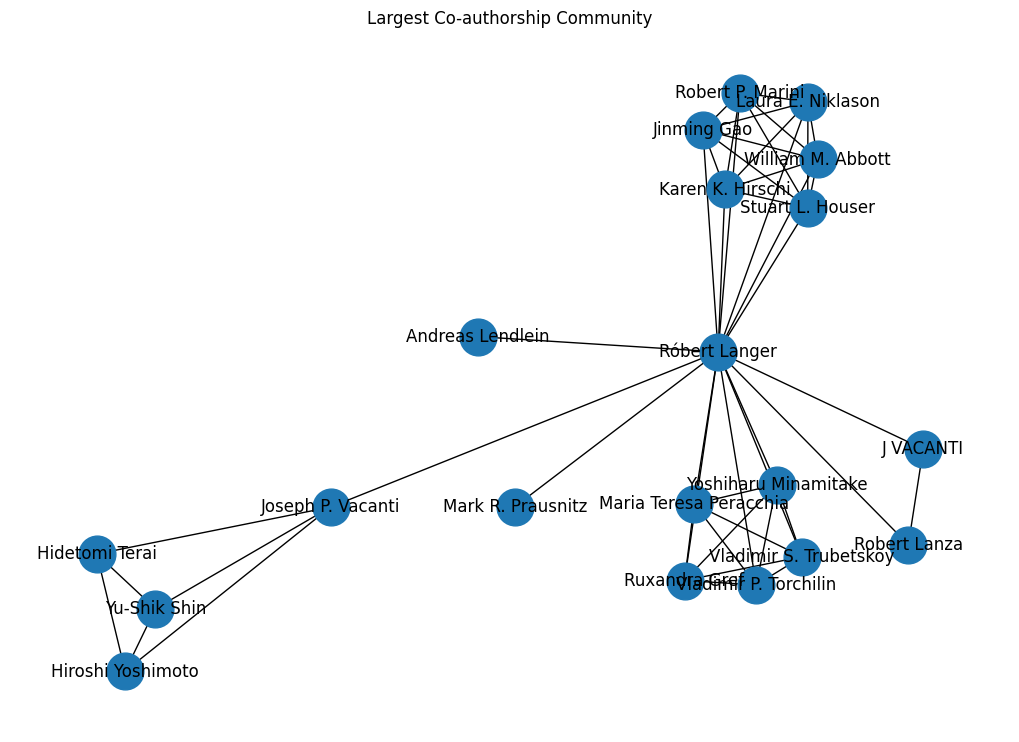

In [17]:
#print out the basic info/stats
print("Number of Nodes (Authors):", G.number_of_nodes())
print("Number of Edges (Collaborations):", G.number_of_edges())

#top 10 most connected authors
degree_centrality = nx.degree_centrality(G)
top_authors = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Authors by Degree Centrality:")
for author, score in top_authors:
    print(f"{author}: {score:.2f}")

#community Detection? (is this how it works?)
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
print(f"Number of Communities Detected: {len(communities)}")

#visualize largest community
largest_community = max(communities, key=len)
H = G.subgraph(largest_community)

plt.figure(figsize=(10, 7))
nx.draw(H, pos, with_labels=True, node_size=700)
plt.title("Largest Co-authorship Community")
plt.show()


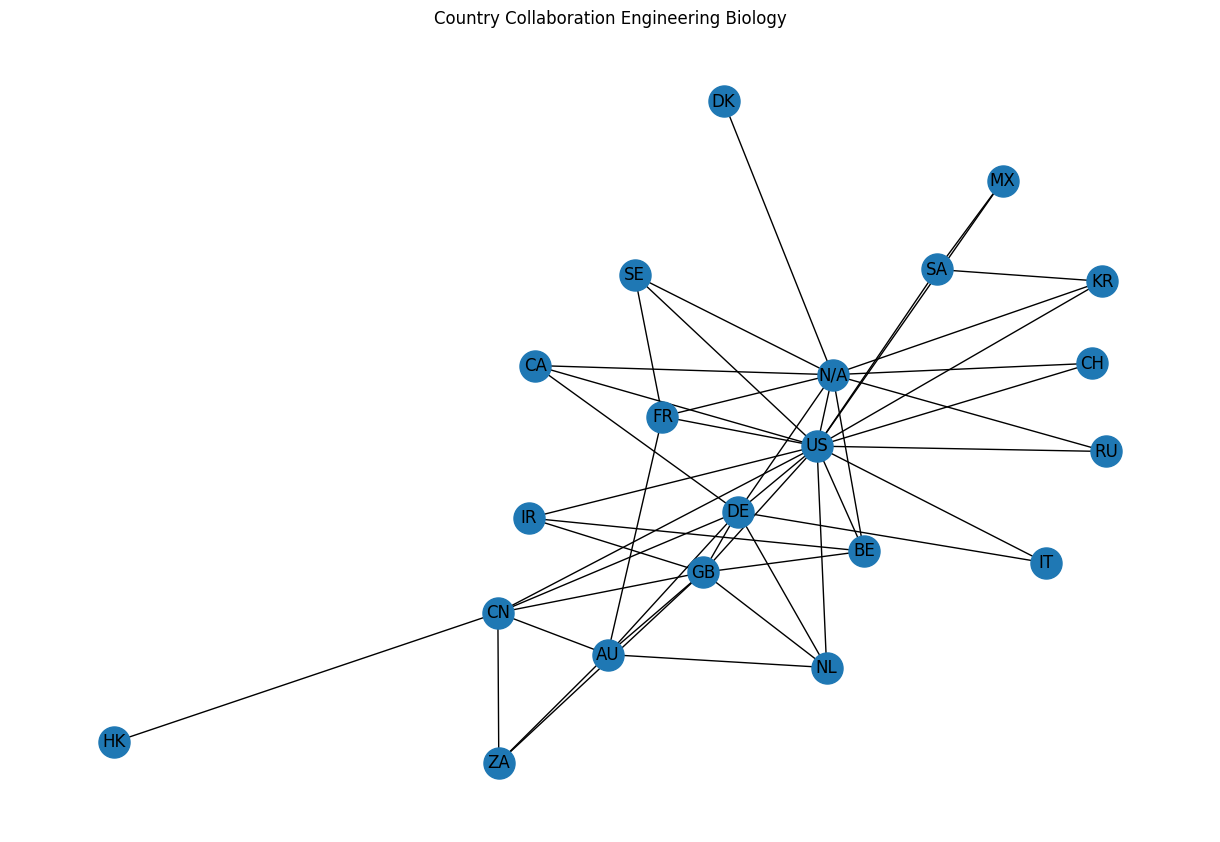

In [20]:
from itertools import combinations
from collections import Counter

country_edges = []

for index, row in df.iterrows():
    countries = list(set(row['Countries'].split(', ')))
    country_edges += list(combinations(countries, 2))

#co-authorships by country
country_pairs = Counter(country_edges)

#attempt at country-level graph
G_country = nx.Graph()

for pair, weight in country_pairs.items():
    G_country.add_edge(pair[0], pair[1], weight=weight)

#plot, but unsure how this will look
plt.figure(figsize=(12, 8))
pos_country = nx.spring_layout(G_country, seed=42)
nx.draw(G_country, pos_country, with_labels=True, node_size=500)
plt.title("Country Collaboration Engineering Biology")
plt.show()


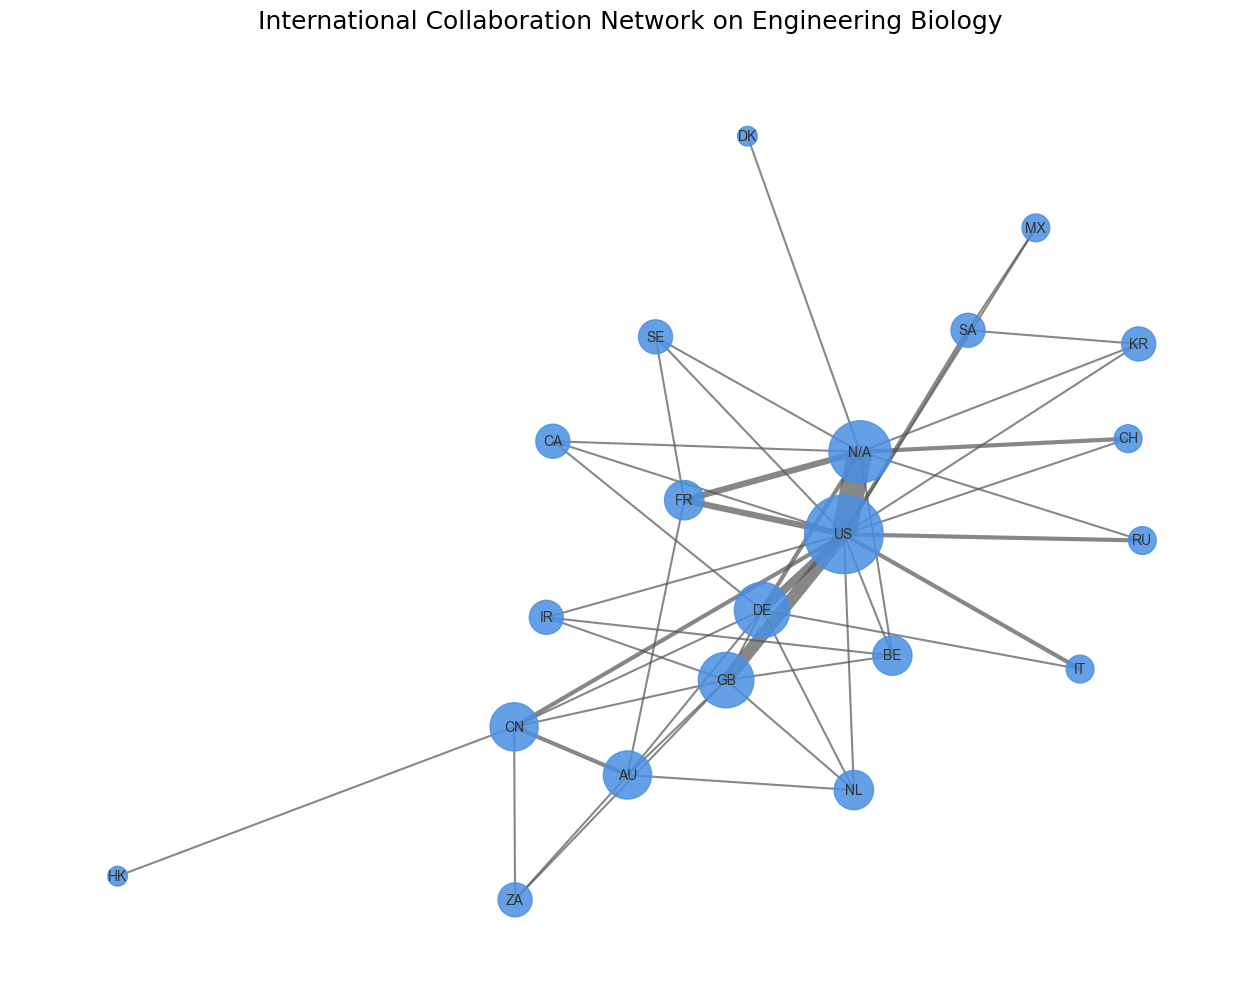

In [21]:
#copy from above
country_edges = []
for index, row in df.iterrows():
    countries = list(set(row['Countries'].split(', ')))
    country_edges += list(combinations(countries, 2))

#copy from above
country_pairs = Counter(country_edges)

#copy from above
G_country = nx.Graph()
for pair, weight in country_pairs.items():
    G_country.add_edge(pair[0], pair[1], weight=weight)

#this and parts below is where I'm caonfused
plt.figure(figsize=(16, 12))
pos_country = nx.spring_layout(G_country, seed=42)

#scale the nodes to make them noticable
node_size = [v * 200 for v in dict(G_country.degree()).values()]

#factor in the weights
edge_width = [d['weight'] * 1.5 for (u, v, d) in G_country.edges(data=True)]

#draw edges. same as before
nx.draw_networkx_edges(G_country, pos_country, width=edge_width, alpha=0.7, edge_color="#555")

#draw nodes. same as before
nx.draw_networkx_nodes(G_country, pos_country, node_size=node_size, node_color="#4a90e2", alpha=0.85)

#draw labels. last attempt didn't work right. remember to play with font size
nx.draw_networkx_labels(G_country, pos_country, font_size=10, font_family="Arial", font_color="#333")

#plt title and display
plt.title("International Collaboration Network on Engineering Biology", fontsize=18, pad=20)
plt.axis('off')  # Hide axes
plt.show()
